In [3]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# mne library to analyse EEG
import mne
from mne import Epochs, pick_types
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf
mne.set_log_level('error') # Avoid long log

# Charging the data

Each subjects perform 14 experimental runs:

1. Baseline, eyes open
2. Baseline, eyes closed
3. Task 1 (open and close left or right fist)
4. Task 2 (imagine opening and closing left or right fist)
5. Task 3 (open and close both fists or both feet)
6. Task 4 (imagine opening and closing both fists or both feet)
7. Task 1
8. Task 2
9. Task 3
10. Task 4
11. Task 1
12. Task 2
13. Task 3
14. Task 4


In [4]:
# Create a list with each tipe of experimental run
openeye_runs = [1]
closedeye_runs = [2]
fists_runs = [3, 7, 11]
imaginefists_runs = [4, 8, 12]
fistsfeet_runs = [5, 9, 13]
imaginefistsfeet_run = [6, 10, 14]

# List with the ID of each participant
participants = [_ for _ in range(1,110)]


# Defining the EEG standard EEG bands. These are indicative situation in which we see appearing this type of waves on healty subjects.
delta_waves = {
    'freq_min': 0.5,
    'f_max': 4
} # normally occur during deep sleep

theta_waves = {
    'freq_min': 4,
    'freq_max': 8
} # transiently during sleep

alpha_waves = {
    'freq_min': 8, 
    'freq_max': 13
} # relaxed but awake state, resting with the eyes closed

beta_waves = {
    'freq_min': 13, 
    'freq_max': 30   
} # attention to tasks or stimuli,logical thinking

gamma_waves = {
    'freq_min': 30, 
    'freq_max': 70  
} # large-scale brain network activity and cognitive phenomena such as working memory, attention



Motor activity often produce alpah and beta waves

In [5]:
# Charging the data
participant = 14

# Get the path to the data
def file_path(participant, run):
    return f'files/S{participant:03}/S{participant:03}R{run:02}.edf'

# Load the data
# Preload = True charges also the data, not just the headers
raw = concatenate_raws([read_raw_edf(file_path(participant, run), preload = True) for run in fists_runs])

# Setting the montage

EEG signal are taken using non ivasive electrode place on the head. The electrode placements follow standard rules, where each position has its own nomenclature.

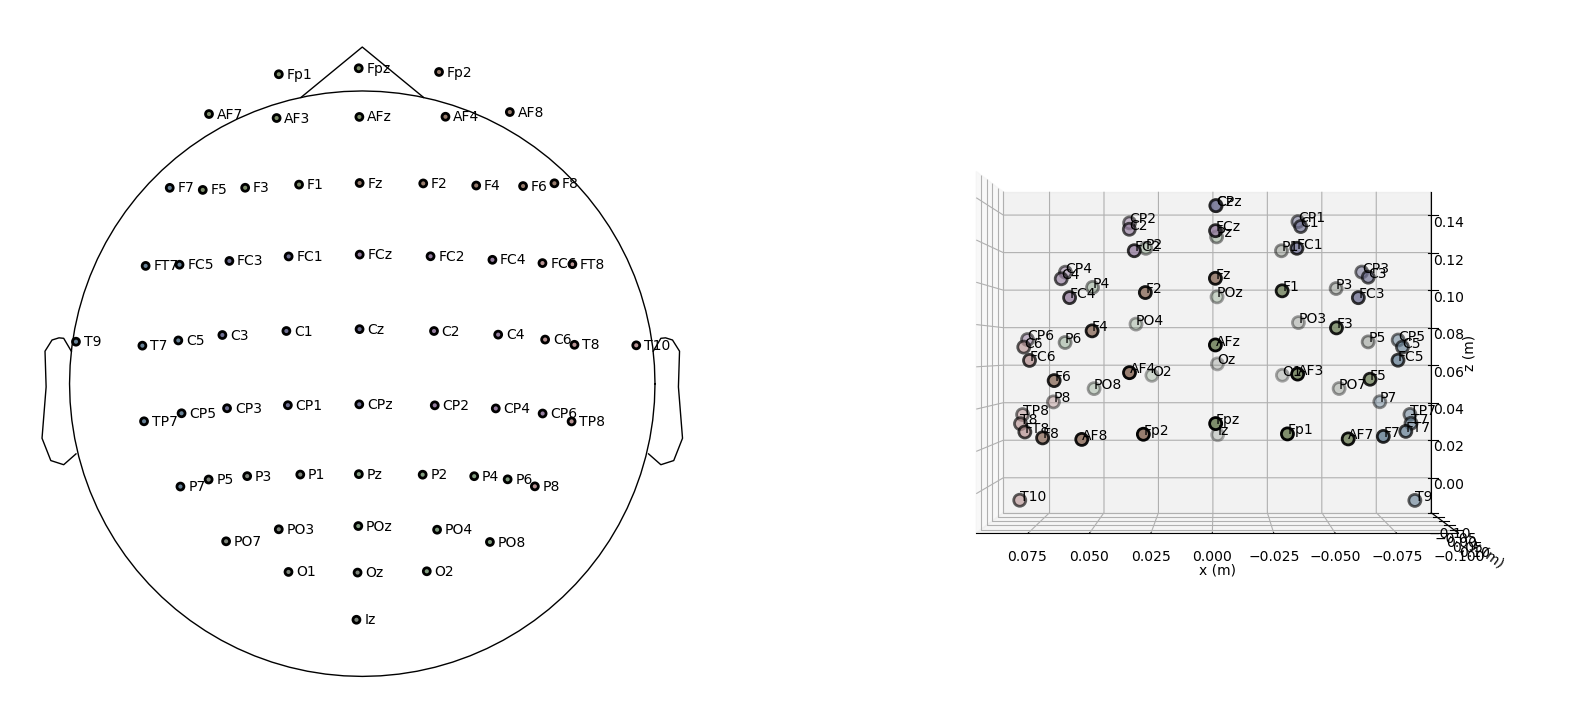

In [6]:
# We choose the "Standard_1020" montage
eegbci.standardize(raw)
montage = mne.channels.make_standard_montage("standard_1020")
raw.set_montage(montage)

# Here we change the names of the electrode to match the standard notation and set the choosen montage on the raw data charged.

# Dictionary with the structure old_name : correct_cases_name. To respect the upper and lower cases of the standard notation for the electrde's position.
replacement = {
    'Fc': 'FC',
    'Cp': 'CP',
    'Af': 'AF',
    'Ft': 'FT',
    'Tp': 'TP',
    'Po': 'PO'   
}

# new_name is the dictionary to use to cange the name of the electrode's positions to respect the usual sandard notataions.
# First get rid of the excessive "." 
new_names = {
    name : name.replace(".", "") for name in raw.info['ch_names']
}   

# Change the lower and upper case of the electrode's names
for key in new_names.keys():
    for old_string, new_string in replacement.items():
        new_names[key] = new_names[key].replace(old_string, new_string)

# Choose the montage and set it for the uploaded data
# montage = 'standard_1020'
raw.rename_channels(new_names)
raw.set_montage(montage)


# Plot the 2D projection and the 3D representation of the choosen montage
fig = plt.figure(figsize=(20, 10))

gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
# Plot the 2D montage
ax1 = fig.add_subplot(gs[0])
raw.info.plot_sensors(ch_type = 'eeg', show_names=True, ch_groups='position', axes=ax1, show=False)

# Plot the 3D montage
ax2 = fig.add_subplot(gs[1], projection='3d')
raw.info.plot_sensors(kind = "3d", ch_type = 'eeg', show_names=True, ch_groups='position', axes=ax2, show=False)

plt.show()


# Apply filter

c:\Users\Stagiaire\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


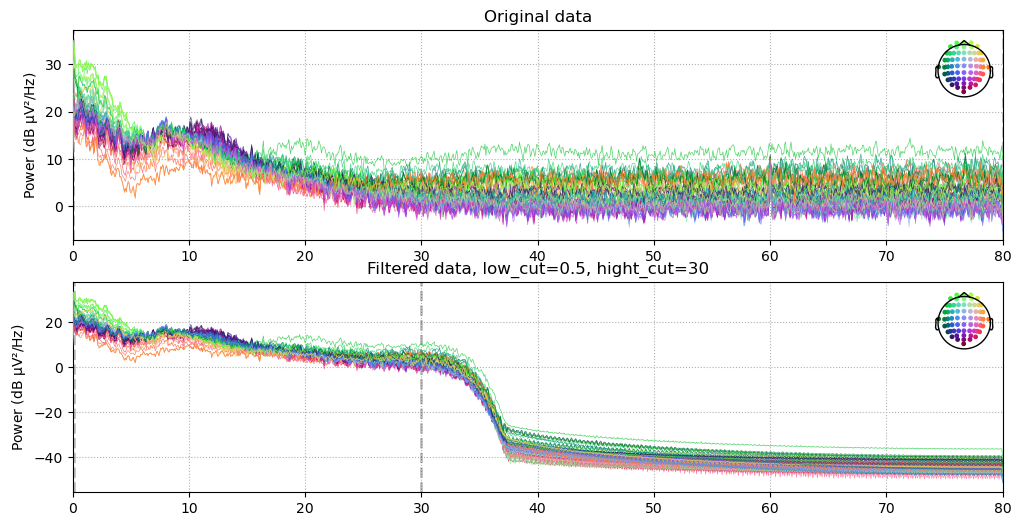

In [7]:
# Filter setting
low_cut = 0.1 # We filter the low frequency to remove slow drift
high_cut = 30 # We filter the high frequency to eliminate noise, and because the motor signals appears mostly as alpha and beta waves

# copy the raw data and apply the filter
raw_filt = raw.load_data().copy().filter(low_cut, high_cut)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6)) 

raw.compute_psd().plot(axes = ax1)
ax1.set_title("Original data")

raw_filt.compute_psd().plot(axes = ax2)
ax2.set_title("Filtered data, low_cut=0.5, hight_cut=30")

plt.show()

In [8]:
# raw.plot(title='original')
# raw_filt.plot(title='filtered')

# ICA

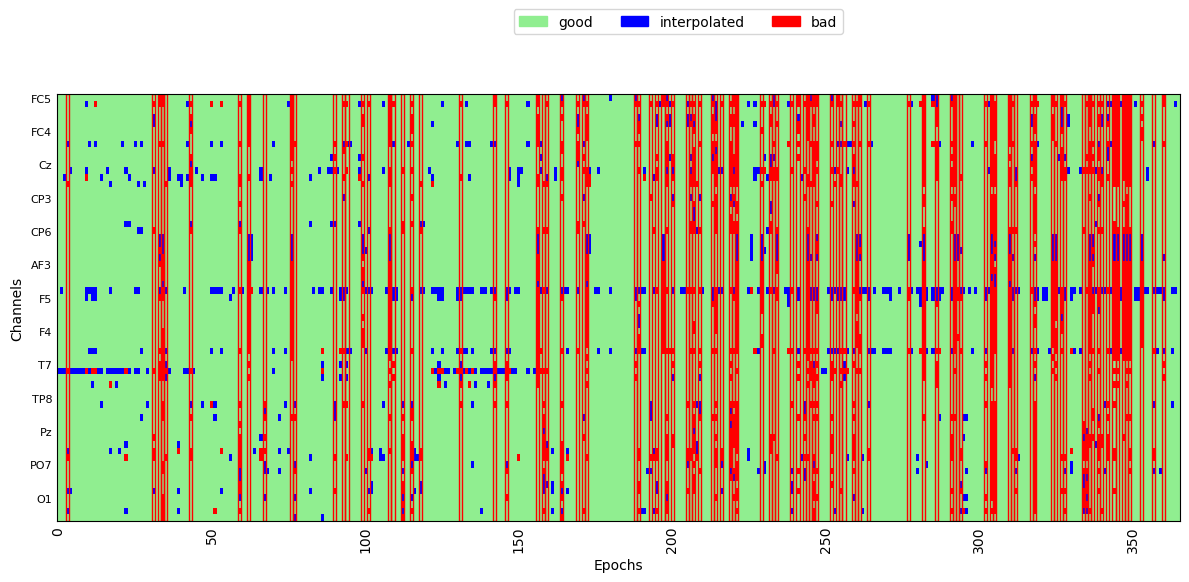

In [9]:
from autoreject import AutoReject


# Filter settings for ICA
ica_low_cut = 1
high_cut = 30

# Creating a raw data to use to compute the ICA
raw_ica = raw.copy().filter(ica_low_cut, high_cut)

# Creating the epochs for the artifact detection and the ICA
time_step = 1 # Coerent with the time-span of the most common artifact (heart, eye blink)
events_ica = mne.make_fixed_length_events(raw_ica, duration=time_step)
epochs_ica = mne.Epochs(raw_ica, events_ica,
                        tmin=0.0, tmax=time_step,
                        baseline=None,
                        preload=True)

# We use the autoreject function to clean clean the data before applying ICA, indeed it automatically 
# determine a threshold to use to find sections of the data that are excessively noisy. 
# This can occur, for example, if a participant scratches their head during a recording, or sneezes, or for various other reasons.

# Instancing the autoreject object
ar = AutoReject(
                random_state=42,
                picks=mne.pick_types(epochs_ica.info, 
                                     eeg=True,
                                     eog=False
                                    ),
                n_jobs=-1, 
                verbose=False
                )

ar.fit(epochs_ica)

reject_log = ar.get_reject_log(epochs_ica)
reject_log.plot('horizontal', aspect='auto');

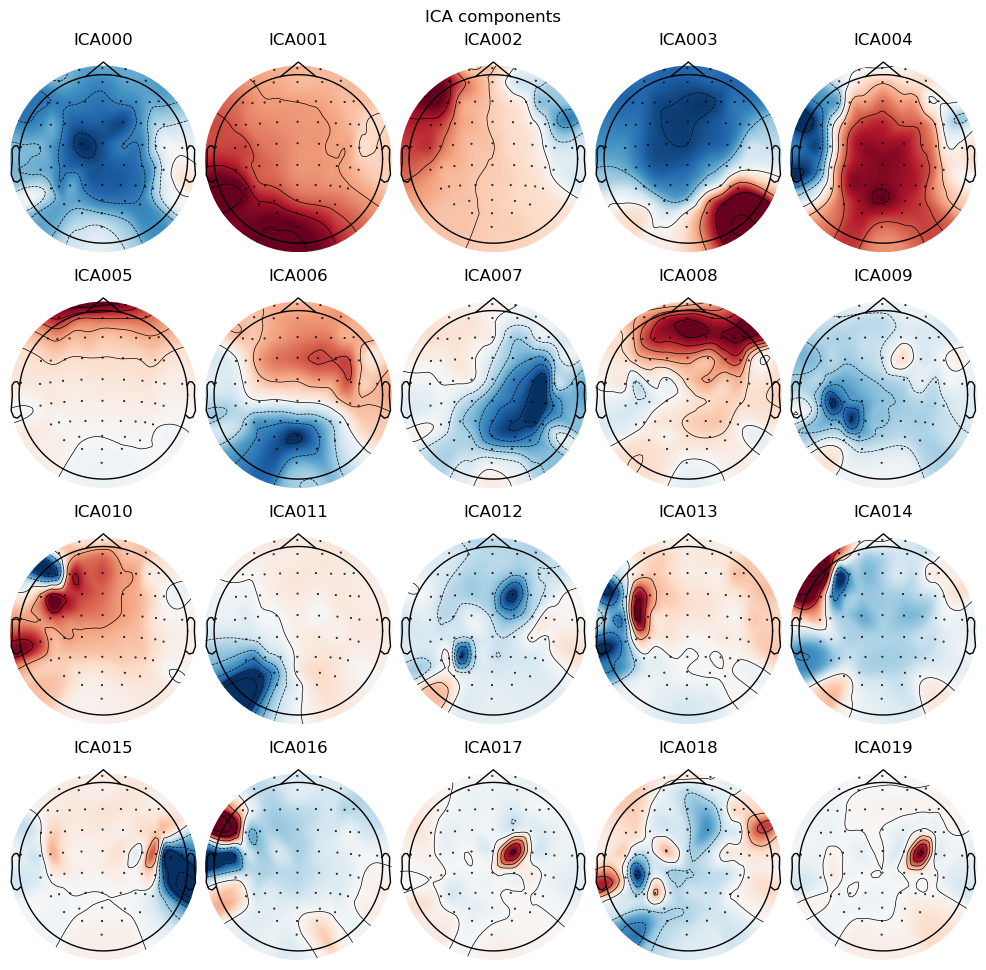

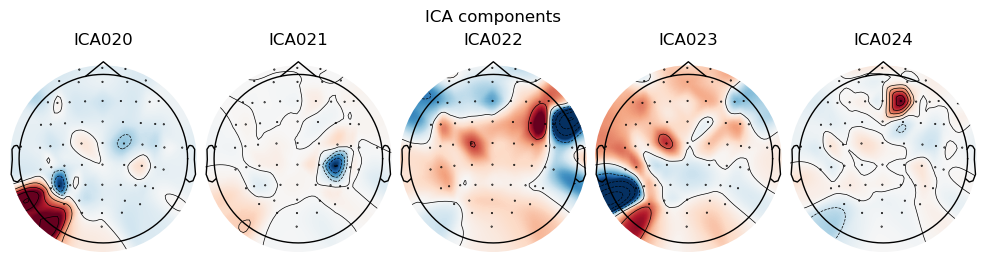

In [10]:
# ICA parameters
random_state = 0   # ensures ICA is reproducible each time it's run
ica_n_components = 25    # Specify n_components as a decimal to set % explained variance

# Fit ICA
ica = mne.preprocessing.ICA(n_components=ica_n_components,
                            random_state=random_state,
                            )
ica.fit(epochs_ica[~reject_log.bad_epochs], decim=3)

# ica.plot_properties(epochs_ica, picks=range(0, ica.n_components_), psd_args={'fmax': high_cut});
ica.plot_components();

Final z threshold = 2.7
The IC indices are:  [5, 8]


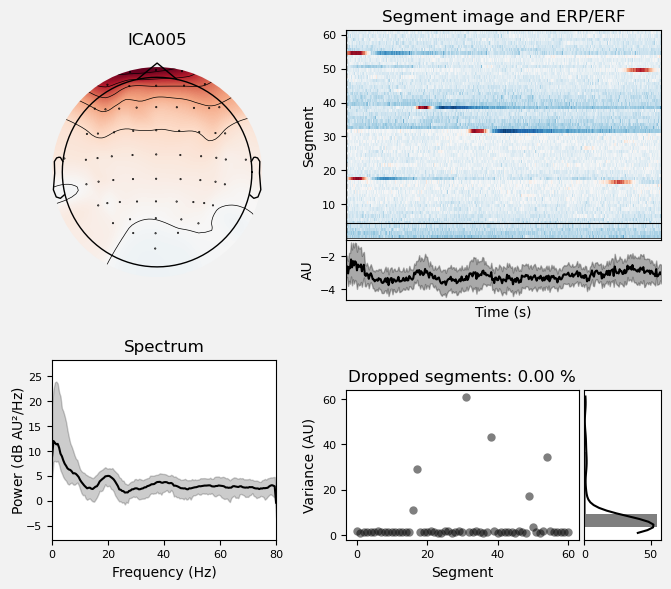

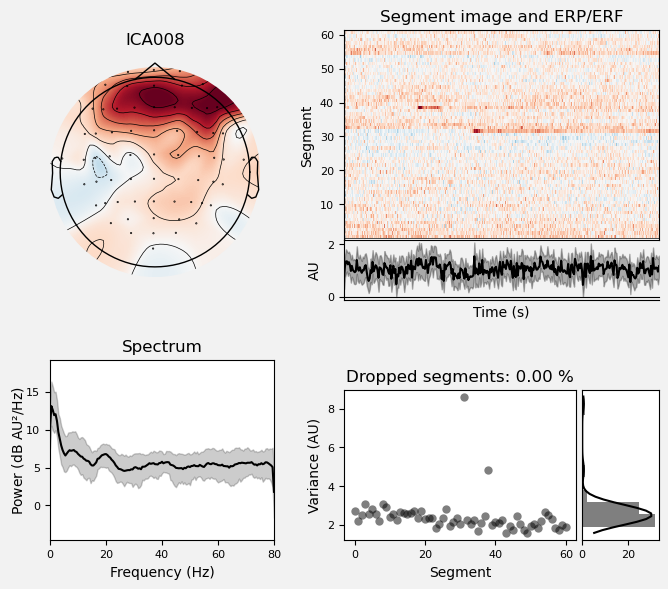

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [11]:
ica.exclude = []
num_excl = 0
max_ic = 2 # Chosing three seems to eliminate the eye movements and blinks.
z_thresh = 3.5
z_step = .05

while num_excl < max_ic:
    eog_indices, eog_scores = ica.find_bads_eog(epochs_ica,
                                                ch_name=['Fp1', 'Fp2', 'AF7', 'AF8', 'F7', 'F8', 'Fpz'], 
                                                threshold=z_thresh
                                                )
    num_excl = len(eog_indices)
    z_thresh -= z_step # won't impact things if num_excl is ≥ n_max_eog 


# assign the bad EOG components to the ICA.exclude attribute so they can be removed later
ica.exclude = eog_indices

print('Final z threshold = ' + str(round(z_thresh, 2)))
print('The IC indices are: ', eog_indices)
# ica.plot_scores(eog_scores); # Plot the socre for each channel choosed
ica.plot_properties(raw, picks=eog_indices)

Here we proceed wth visual inspection to select oter IC that represents other artifacts. From the topmap above it seems clear that IC002 represents an eye artifact. While inspecting the signals it sems clear that IC001 represent a eart artifact.

In [12]:
# inspecting the signal
ica.plot_sources(epochs_ica)

In [13]:
# We add the ICA001 that shoudl be the heart artifact and ICA002 that is eye blink
ica.exclude = [5, 8, 1, 2]

In [ ]:
# Here we try to elimiate the ECG signal, but it doesn't work

# ica.exclude = []
# # find which ICs match the ECG pattern
# num_excl = 0
# max_ic = 1
# z_thresh = 3.5
# z_step = .05

# while num_excl < max_ic: 
#     ecg_indices, ecg_scores = ica.find_bads_ecg(epochs_ica, 
#                                                 ch_name='T9', 
#                                                 threshold=z_thresh)
    
#     num_excl = len(ecg_indices)
#     z_thresh -= z_step # won't impact things if num_excl is ≥ n_max_eog 

# # # barplot of ICA component "ECG match" scores
# ica.exclude = ecg_indices
# ica.plot_scores(ecg_scores);

# # # plot diagnostics
# # ica.plot_properties(epochs_ica)

# # # # plot ICs applied to raw data, with ECG matches highlighted
# # ica.plot_sources(epochs_ica)

# # # plot ICs applied to the averaged ECG epochs, with ECG matches highlighted
# # ica.plot_sources(ecg_evoked)

# ERP

The event_dict is:  {'T0': 1, 'T1': 2, 'T2': 3}


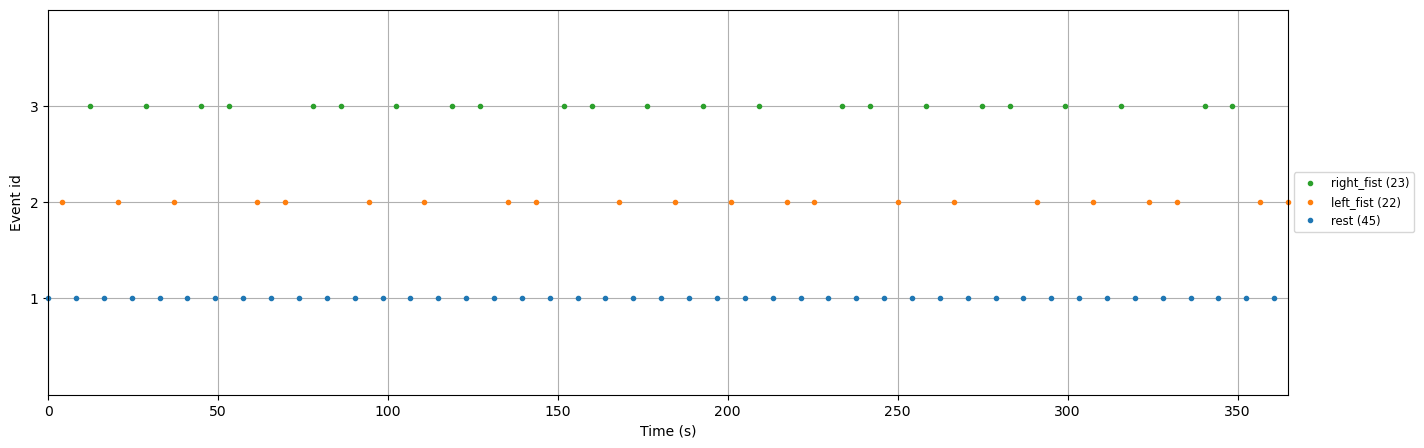

In [14]:
# Obtain the numpy array with the timing and the duration of each event and the dictionary with the name of the events.
# The timing is given as the number of the imput of the EEG. To get the time in second we need to multiplay it by the frequency 
# of the imput intake: 160Hz
events, events_dict = mne.events_from_annotations(raw_filt)
print('The event_dict is: ', events_dict)

# Making it easyer to read the events
event_mapping = {
    1: 'rest',
    2: 'left_fist',
    3: 'right_fist'
}
event_id = {v:k for k,v in event_mapping.items()}

# Drawing the distributon of the events
fig, ax = plt.subplots(figsize=[20, 5])
mne.viz.plot_events(events, raw_filt.info['sfreq'],  
                    event_id=event_id,                    
                    axes=ax)
plt.show()

## Creating the epochs

In [15]:
epoch_duration = 656. / raw_filt.info['sfreq']


# Epoching: We start the epochs 1 second before the onset signal
tmin =  -1.  # start of each epoch (in sec)
tmax =  4.1  # end of each epoch (in sec)
baseline = (-1, 0) # for the baseline correction we choose the interval that reflect the resting state before the event

# Create epochs
epochs = mne.Epochs(raw_filt,
                    events, event_id,
                    tmin = tmin,
                    tmax = tmax,
                    preload=True,
                    baseline = baseline
                   ) 

print(epochs.drop_log)

(('NO_DATA',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('BAD boundary',), ('BAD boundary',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('BAD boundary',), ('BAD boundary',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('TOO_SHORT',))


C:\Users\Stagiaire\AppData\Local\Temp\ipykernel_2268\1902094319.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


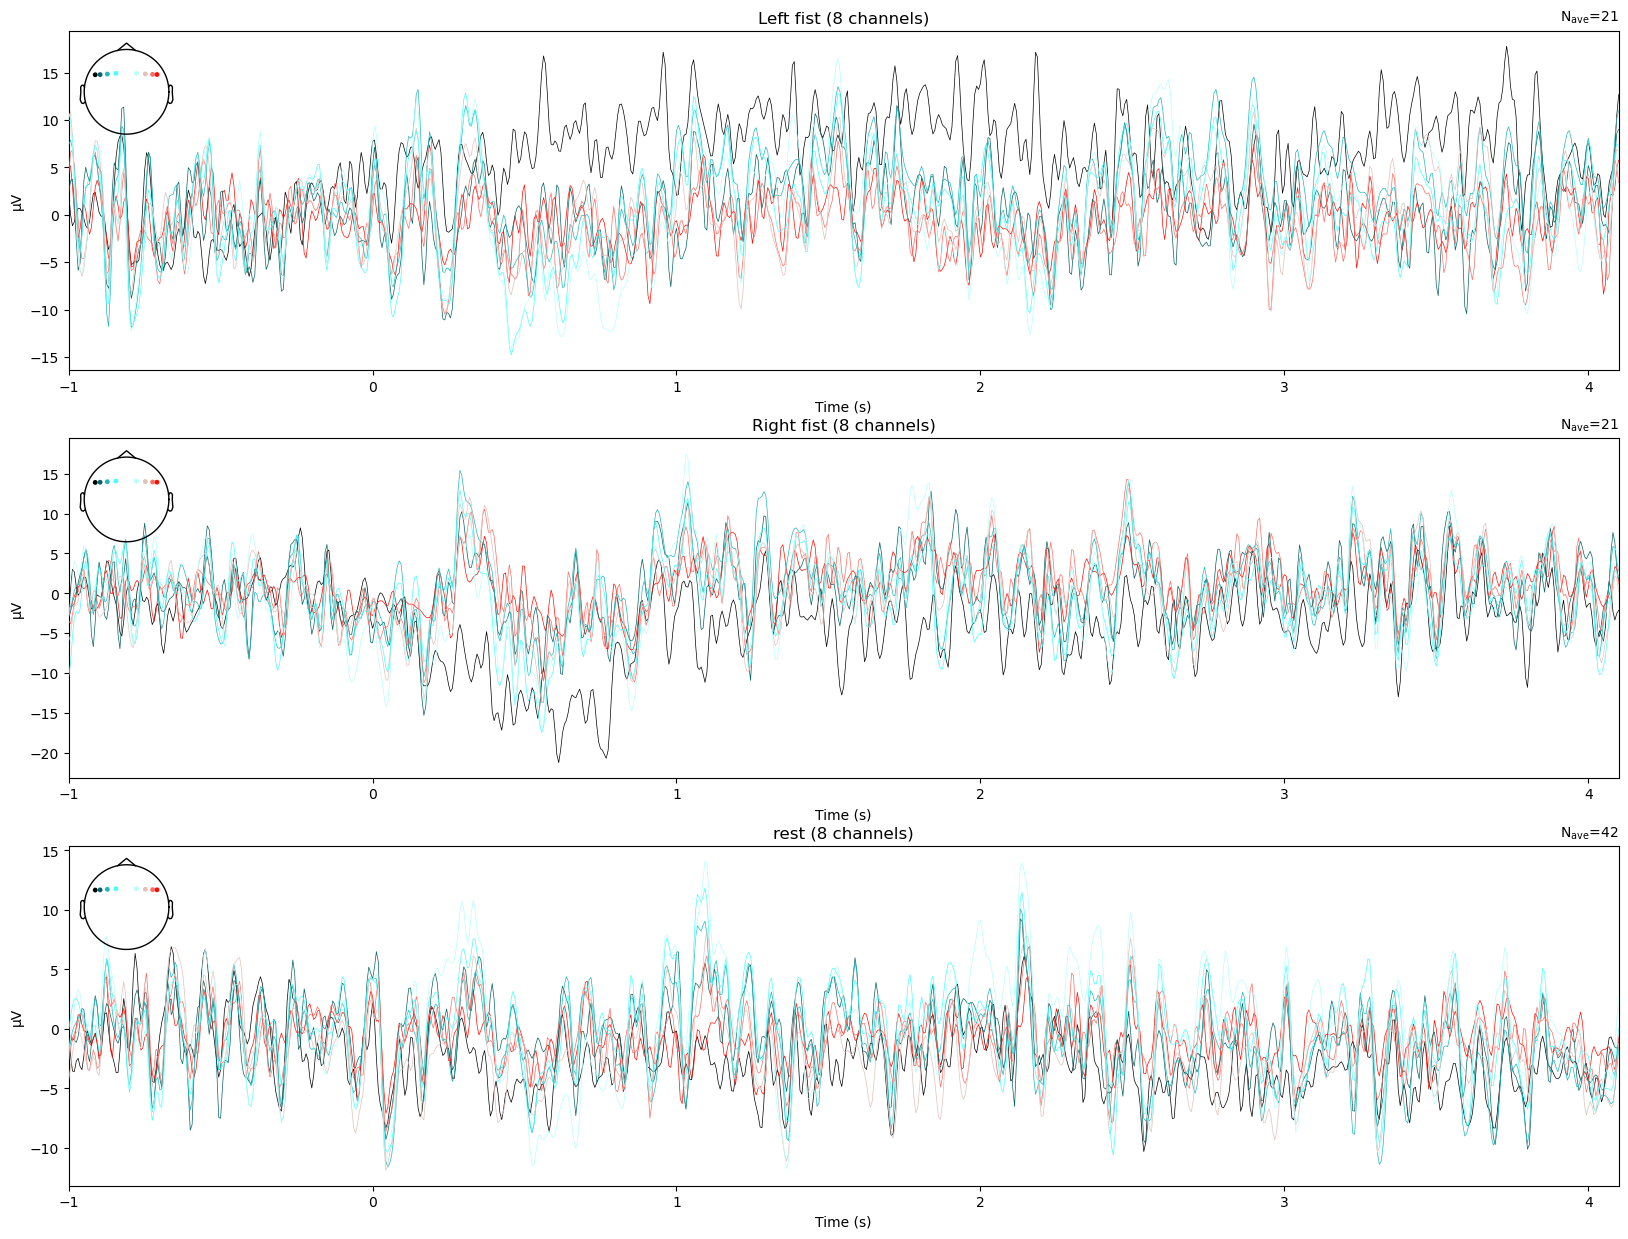

In [20]:
# appplying the ica to the epochs object.
epochs_postica = ica.apply(epochs.copy())

# Plotting the evked post ICA
fig, ax = plt.subplots(3,1, figsize = [20,15])


motor_system = ['FT7', 'FT8', 'FC5', 'FC6', 'FC3', 'FC4', 'FC1', 'FC2']

epochs_postica['left_fist'].average().plot(picks = motor_system, axes=ax[0],show=False, titles = 'Left fist');
epochs_postica['right_fist'].average().plot(picks = motor_system, axes=ax[1], show=False, titles = 'Right fist');
epochs_postica['rest'].average().plot(picks = motor_system, axes=ax[2],show=False, titles = 'rest');

fig.show()

<Epochs | 84 events (all good), -1 – 4.1 s (baseline -1 – 0 s), ~33.6 MB, data loaded,
 'rest': 42
 'left_fist': 21
 'right_fist': 21>


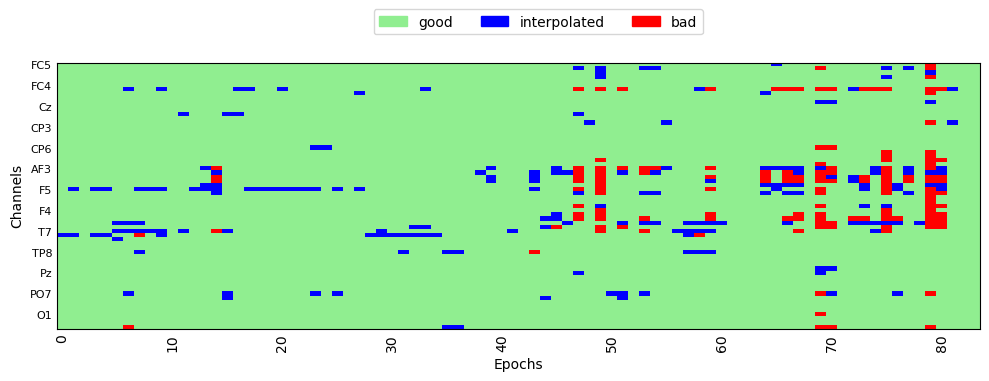

In [ ]:
# Recomputing and appplying autoreject to eliminate bad epochs and channels
ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                picks=mne.pick_types(epochs_postica.info, 
                                     eeg=True,
                                     eog=False
                                    ),
                n_jobs=-1, 
                verbose=False
                )

epochs_clean, reject_log_clean = ar.fit_transform(epochs_postica, return_log=True)

print(epochs_clean)

fig, ax = plt.subplots(figsize=[10, 4])
reject_log_clean.plot('horizontal', aspect='auto', ax=ax)
plt.show()

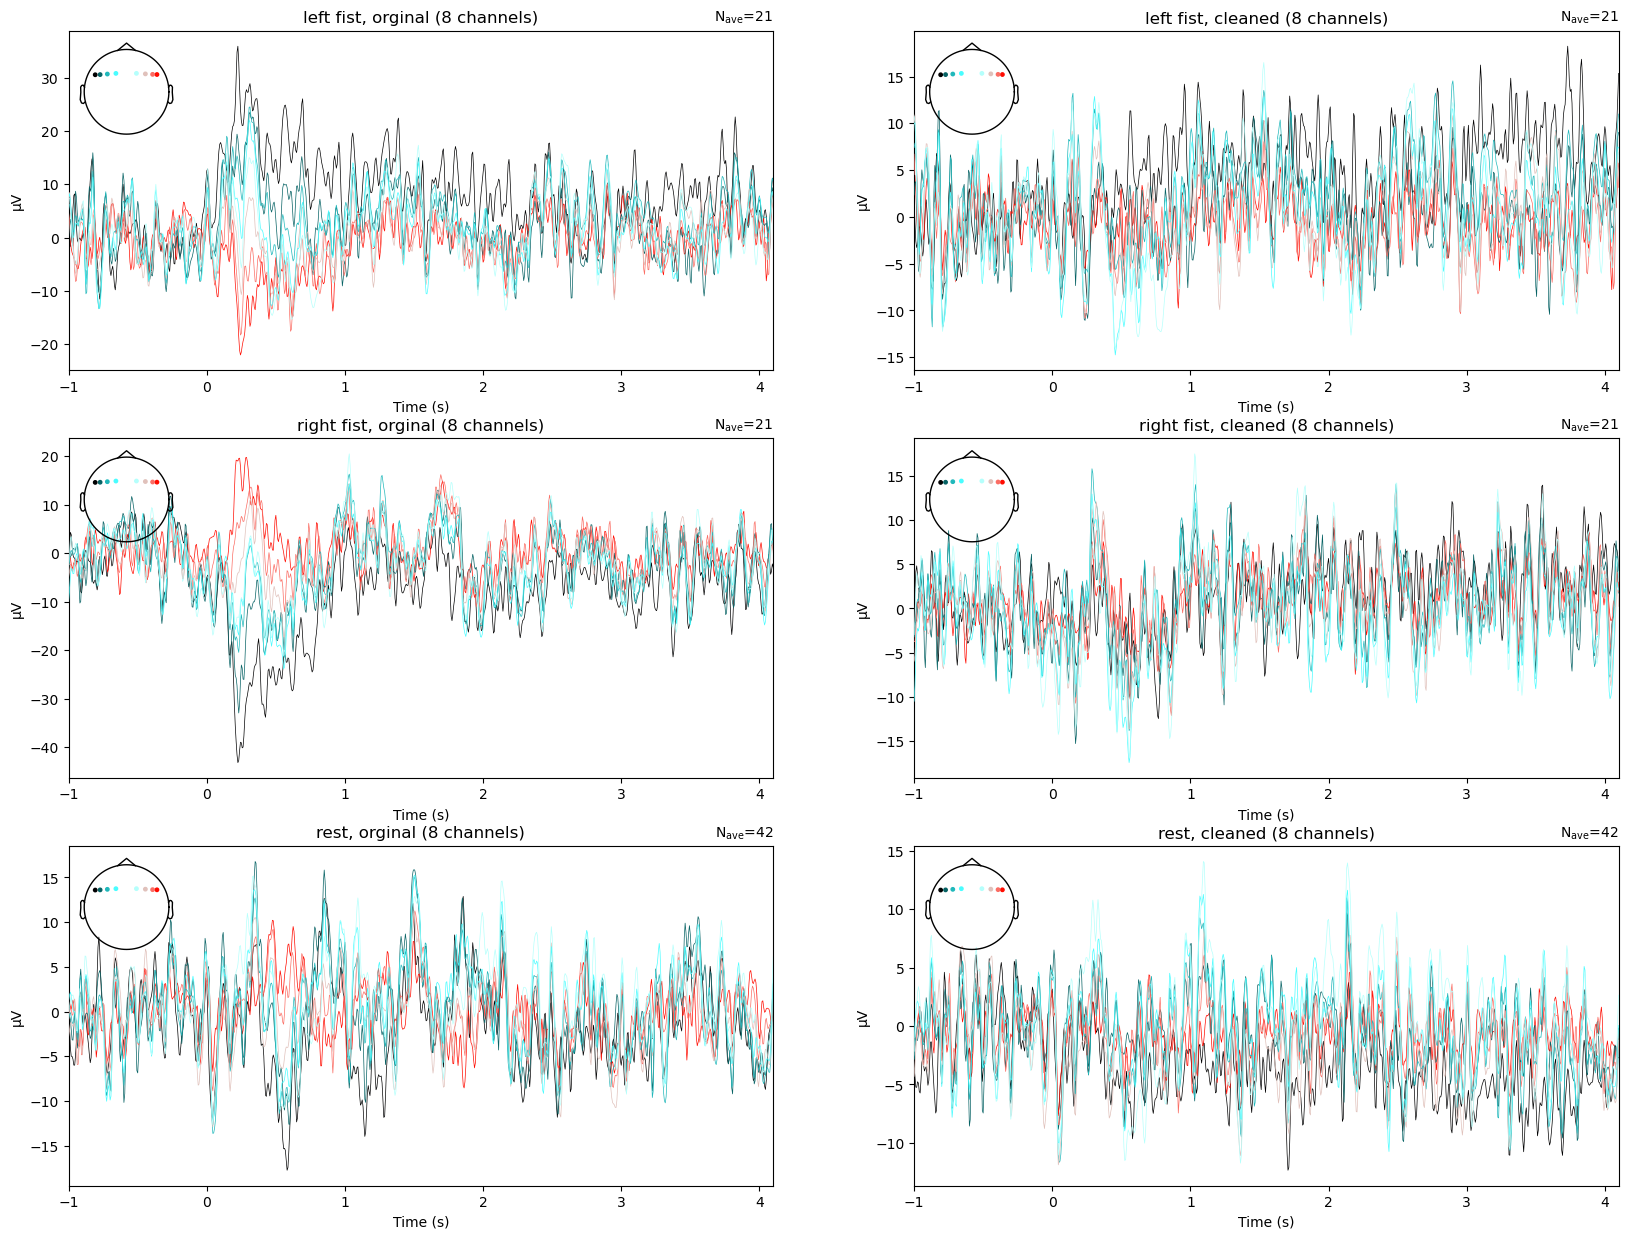

In [22]:
fig, ax = plt.subplots(3, 2, figsize=[20, 15])

epochs['left_fist'].average().plot(picks = motor_system, axes=ax[0, 0], show=False, titles='left fist, orginal');
epochs_clean['left_fist'].average().plot(picks = motor_system, axes=ax[0, 1], show=False, titles = 'left fist, cleaned');
epochs['right_fist'].average().plot(picks = motor_system, axes=ax[1, 0], show=False, titles='right fist, orginal');
epochs_clean['right_fist'].average().plot(picks = motor_system, axes=ax[1, 1], show=False, titles = 'right fist, cleaned');
epochs['rest'].average().plot(picks = motor_system, axes=ax[2, 0], show=False, titles='rest, orginal');
epochs_clean['rest'].average().plot(picks = motor_system, axes=ax[2, 1], show=False, titles = 'rest, cleaned');

--------------rest--------------


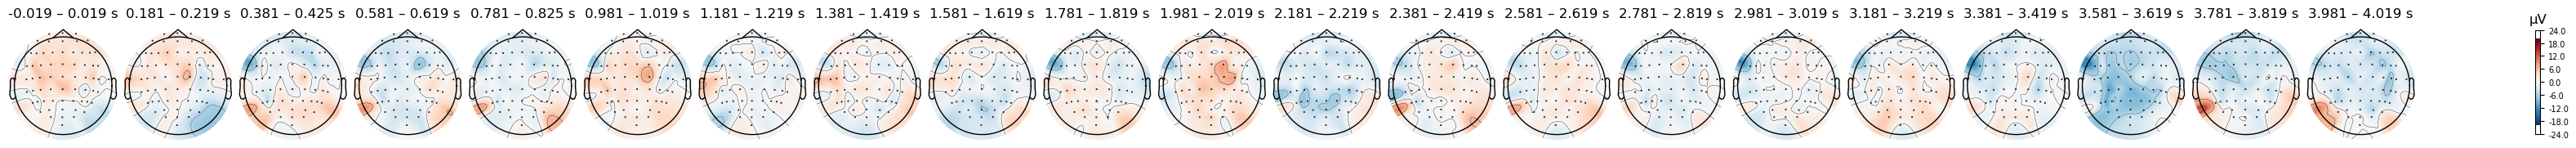

--------------left_fist--------------


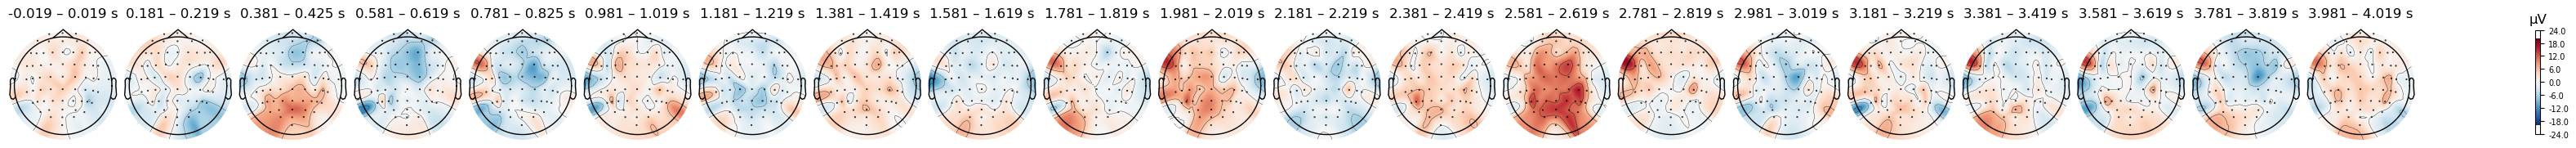

--------------right_fist--------------


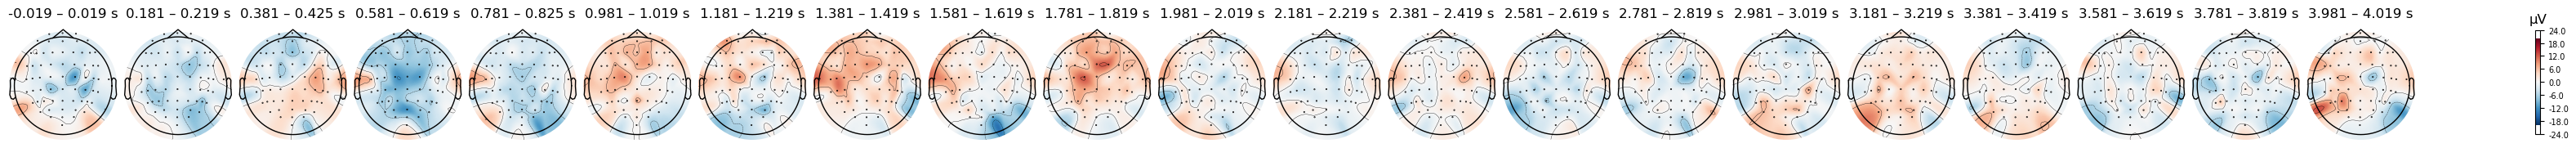

In [23]:
times = np.arange(0, tmax, 0.2)

for event in epochs_clean.event_id.keys():
    print("--------------" + event + "--------------")
    epochs_clean[event].average().plot_topomap(times=times, average=0.05, vlim=(-20, 20));


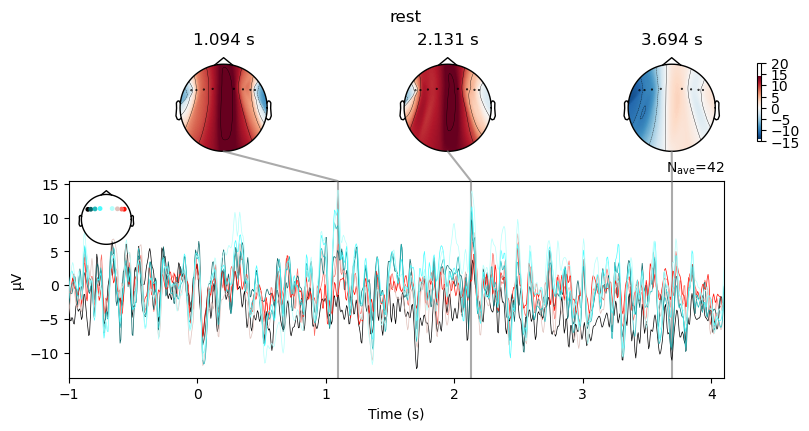

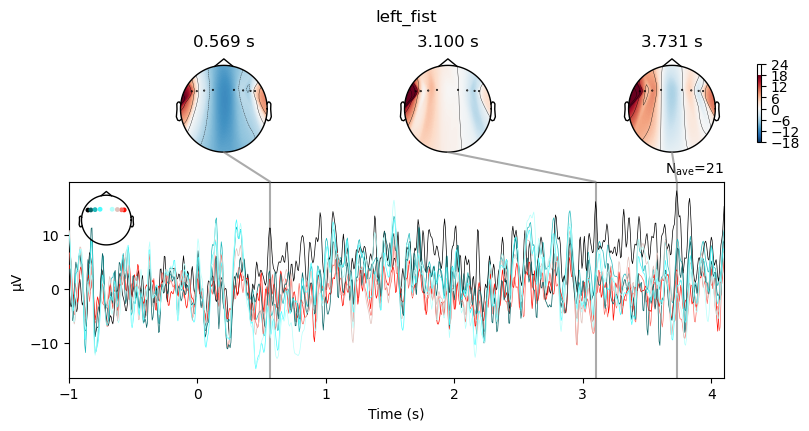

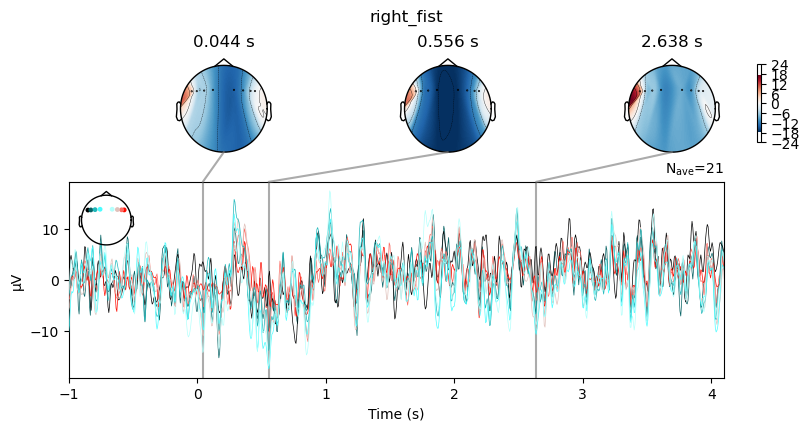

In [24]:
conditions = ['rest', 'left_fist', 'right_fist']
epochs = epochs_clean

# Create three evoked objects, each one consist of the average across trials for a single condition
evokeds = {c:epochs[c].average() for c in conditions}

for c in evokeds.keys():
    evokeds[c].plot_joint(picks = motor_system, title=c)

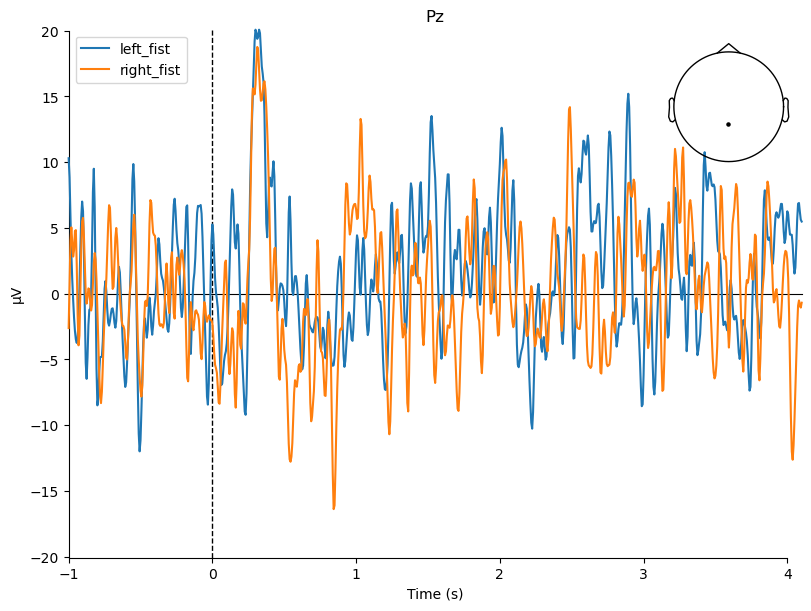

[<Figure size 800x600 with 2 Axes>]

In [25]:
choice_16_C = ['Fz', 'Cz'] 
choice_16_L = ['FC3', 'T7', 'C3', 'CP3', 'P7', 'P3'] 
choice_16_R = ['FC4', 'T8', 'C4', 'CP4', 'P8', 'P4']
choice_16 = choice_16_C + choice_16_L + choice_16_R

mne.viz.plot_compare_evokeds([evokeds['left_fist'], evokeds['right_fist']], picks = 'Pz')

# Re-reference data
The choice of the reference will influence the amplitude values at each channel, it will influence where ERP effects are identified their polarity, and possibly how large they are.
Here we will chose between one of these two possiblities :
* Average reference : instead of selecting a specific electrode(s) as reference we subtract the average potential across all electrode from each indivdual electrode. It works best when there are a lot of electrode.


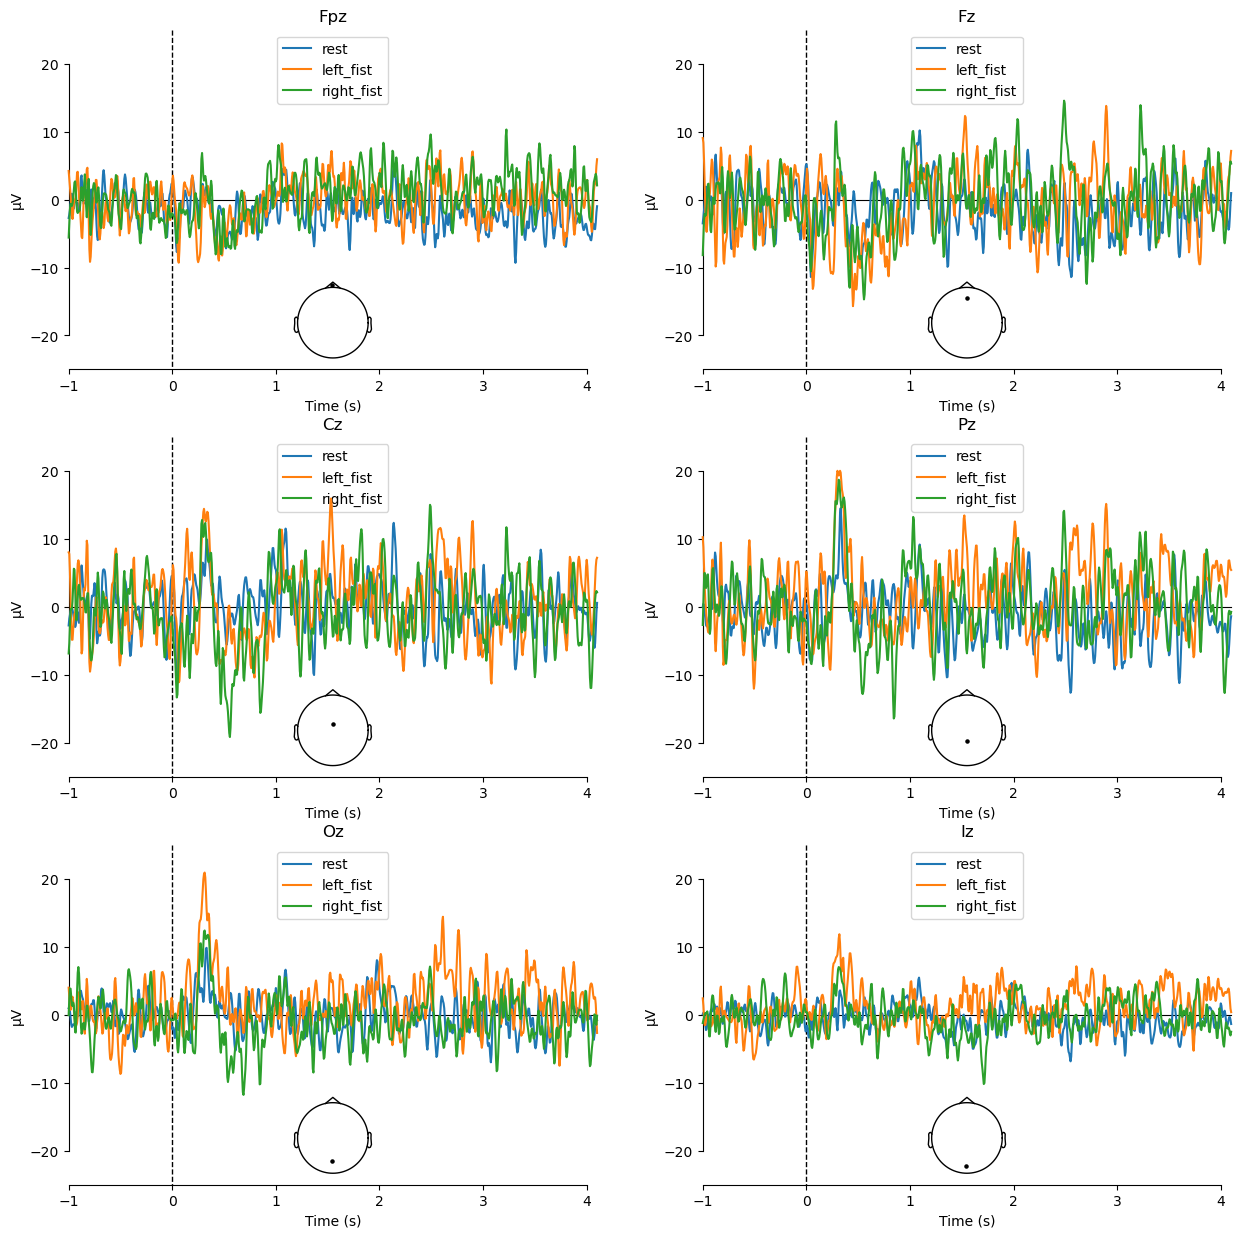

In [59]:

channels = ['Fpz', 'Fz', 'Cz', 'Pz', 'Oz', 'Iz']

# create a figure with 4 subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# plot each channel in a separate subplot
for idx, chan in enumerate(channels):
    mne.viz.plot_compare_evokeds(evokeds, 
                                picks = chan,
                                ylim={'eeg':(-25, 25)},
                                show_sensors='lower center',
                                legend='upper center',
                                axes=axes.reshape(-1)[idx],
                                show=False
                                );
plt.show()    


## Averaged

In [29]:
evokeds_avgref = {c:evokeds[c].copy().set_eeg_reference(ref_channels = 'average') for c in evokeds.keys()}

Here we plot the waveforms at the central channel after applying the average re-referencing.

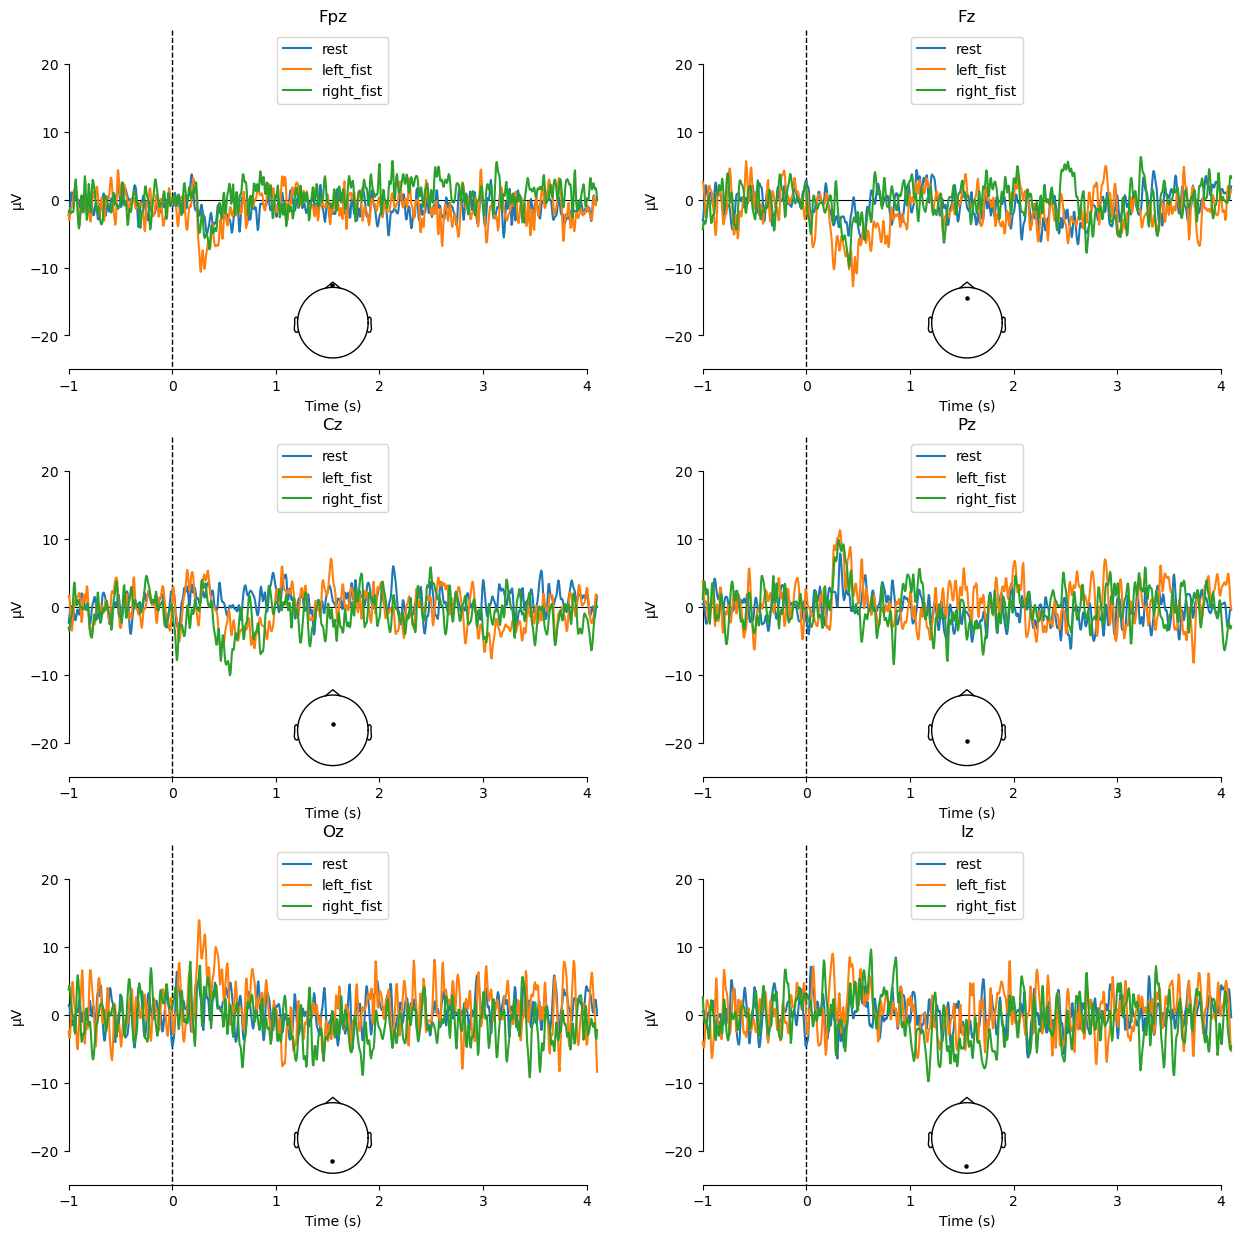

In [58]:
channels = ['Fpz', 'Fz', 'Cz', 'Pz', 'Oz', 'Iz']

# create a figure with 4 subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# plot each channel in a separate subplot
for idx, chan in enumerate(channels):
    mne.viz.plot_compare_evokeds(evokeds_avgref, 
                                picks = chan,
                                ylim={'eeg':(-25, 25)},
                                show_sensors='lower center',
                                legend='upper center',
                                axes=axes.reshape(-1)[idx],
                                show=False
                                );
plt.show()    

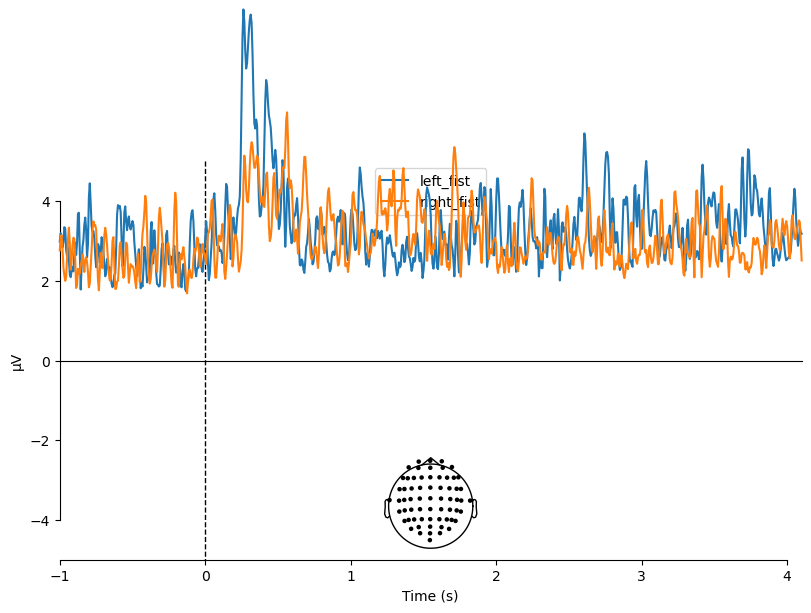

In [50]:
mne.viz.plot_compare_evokeds([evokeds_avgref['left_fist'], evokeds_avgref['right_fist']],
                                ylim={'eeg':(-5, 5)},
                                show_sensors='lower center',
                                legend='upper center',
                                );

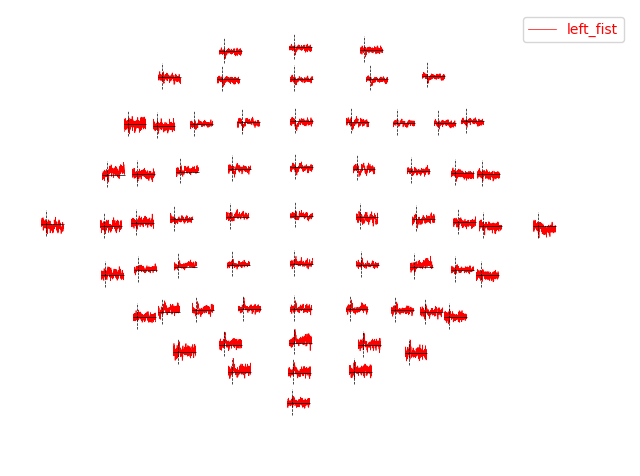

In [53]:
evokeds_avgref['left_fist'].pick(picks='eeg').plot_topo(color="r");

## Mastoid reference

In [61]:
evokeds_mastoidref = {c:evokeds[c].copy().set_eeg_reference(ref_channels=['T9', 
                                                                          'T10'
                                                                          ]
                                                            ) 
                      for c in evokeds.keys()
                      }

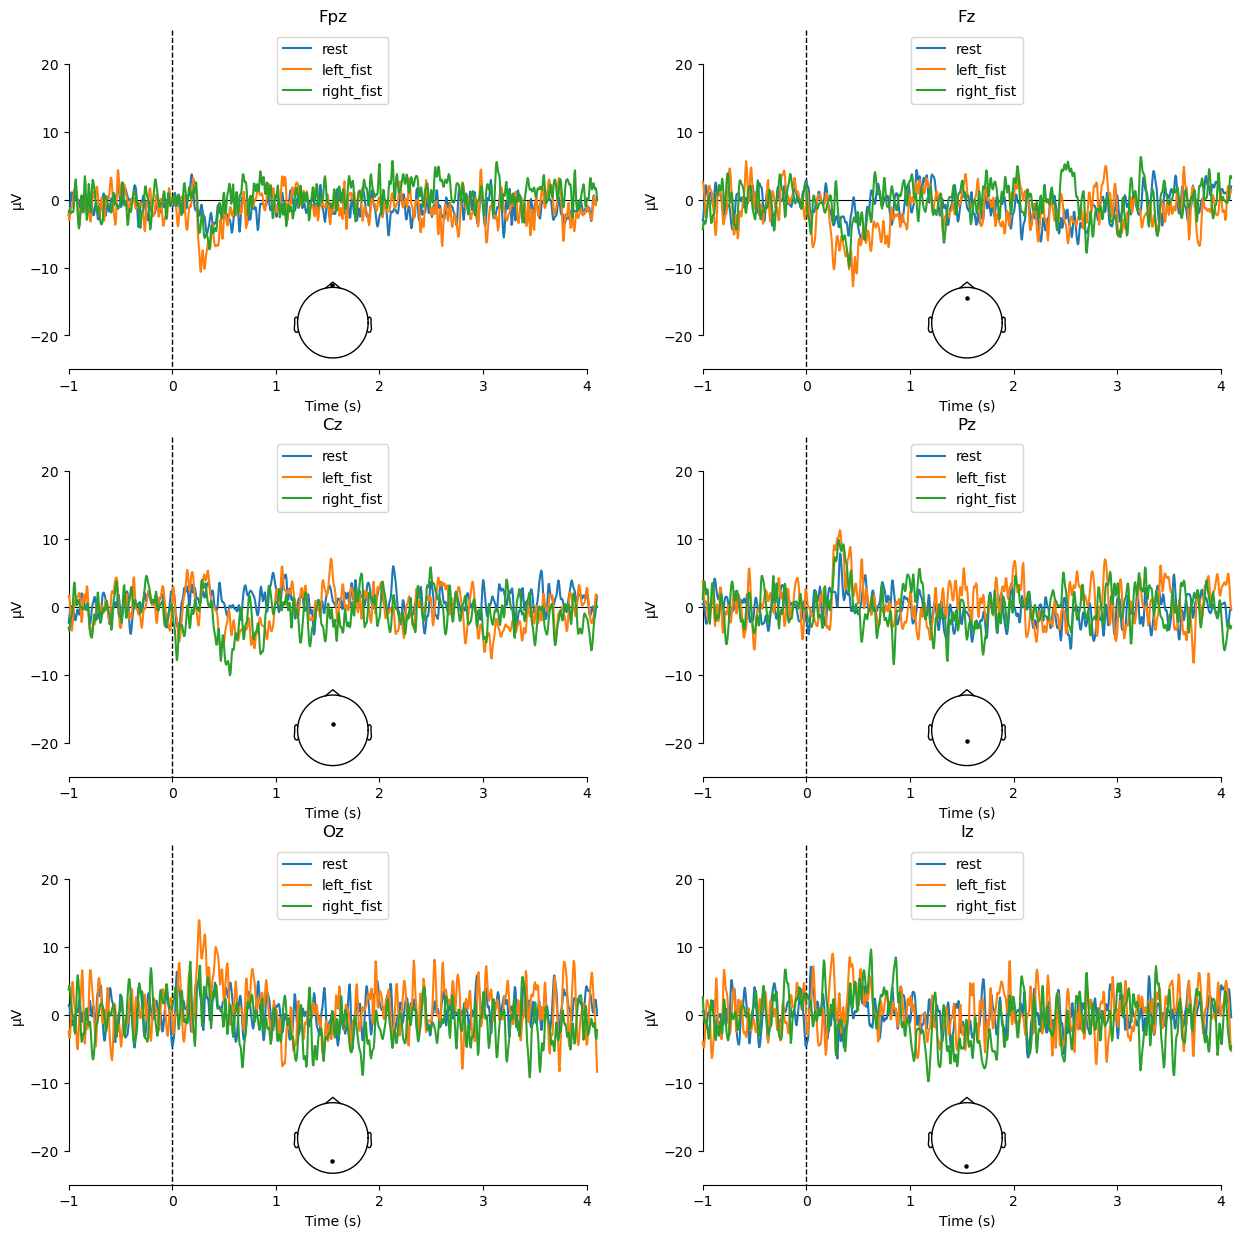

In [62]:
channels = ['Fpz', 'Fz', 'Cz', 'Pz', 'Oz', 'Iz']

# create a figure with 4 subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# plot each channel in a separate subplot
for idx, chan in enumerate(channels):
    mne.viz.plot_compare_evokeds(evokeds_avgref, 
                                picks = chan,
                                ylim={'eeg':(-25, 25)},
                                show_sensors='lower center',
                                legend='upper center',
                                axes=axes.reshape(-1)[idx],
                                show=False
                                );
plt.show()    